In [1]:
import sys
sys.path.append("../../")

import requests
import io
import pandas as pd
import numpy as np
import outputformat as ouf
from datetime import datetime
import re
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm
import unicodedata

import spacy
from pprint import pprint
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from itertools import combinations

import bechdelai.data.wikipedia as wiki
import bechdelai.data.tmdb as tmdb
from bechdelai.data.display import show_movie_suggestions_get_id

In [2]:
def age(birthdate,release_date):
    """
    Compute age at release_date for a person born in birthdate
    Parameters
    ----------
    birthdate : datetime
    release_date : datetime
        

    Returns
    -------
    int
        age in years

    """
    # Difference in years 
    year_difference = release_date.year - birthdate.year
    
    # Check if birthday happened before or after release date
    one_or_zero = ((release_date.month, release_date.day) < (birthdate.month, birthdate.day))
        
    # If release before birthday -> substract 1
    # If release after birthday -> substract 0
    age = year_difference - one_or_zero
        
    return age

def compute_cast_age(cast_df,release_date):
    """
    Compute age at release_date for each actor/actress in the cast_df
    Parameters
    ----------
    cast_df : DataFrame
                should contain the collumn id with the TMDB id of each actor/actress
    release_date : datetime
        

    Returns
    -------
    numpy.ndarray
        with age in years for each person in cast_df (None if birthday is not available)

    """
    age_at_release = np.repeat(None,len(cast_df))
    for i,row in cast_df.iterrows():
        birthday = tmdb.get_person_details_from_id(row['id'])['birthday']
        try:
            age_at_release[i] = age(datetime.strptime(birthday, '%Y-%m-%d'),release_date)
        except TypeError:
            age_at_release[i] = None
    return age_at_release
    

def get_tmdb_cast_data(query,release_year):
    """
    Scrap TDMD cast data for movie query

    Parameters
    ----------
    query : str
           name of the movie
    release_year : int
            year of release. Allows to choose the right movie when multiple movies with same name
        

    Returns
    -------
    numpy.ndarray
        with age in years for each person in cast_df (None if birthday is not available)
    
    """
    data = tmdb.search_movie_from_query(query)
    
    # find most probable id -> same (or closest) release year
    movie_id = ''
    release_year_error = np.Inf # should be min
    # look at the 5 first matches to choose the one that was release closer to release_year
    for res in data["results"][:5]:
        if ('release_date' not in res.keys()):
            continue
        try:
            res_release_year = int(res['release_date'][:4])
        except ValueError:
            continue
        if res_release_year==release_year:
            movie_id = res['id']
            break
        elif abs(res_release_year-release_year)<release_year_error:
            movie_id = res['id']
            release_year_error = abs(res_release_year-release_year)
    
    
    # get release date
    release_date = tmdb.get_movie_details_from_id(movie_id)['release_date']
    release_date = datetime.strptime(release_date, '%Y-%m-%d')
    # get casting data
    data = tmdb.get_movie_cast_from_id(movie_id)
    cast_df = pd.DataFrame(data["cast"])
    
    # only use simple quotation marks'
    cast_df.replace(regex=r'\"',value="'",inplace=True) 
    
    #remove any accents
    cast_df['name'] = cast_df['name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    cast_df['character'] = cast_df['character'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # complete with actors/actress ages
    cast_df['age_at_release'] = compute_cast_age(cast_df,release_date)

    return cast_df

def get_character_short_name(name):
    """
    Characters' names as they are extracted from TMDB can be formatted in different ways.
    When characters are refered by a nickname, it's commonly presented between \' or \"
    
    Parameters
    ----------
    name : str
           character's name
        

    Returns
    -------
    str
        the character's nickname as presented between quotation marks or the original name
    """
    nickname = re.search(r'(\'|\")(.*?)(\'|\")',name)
    if nickname == None:
        name = name.split(' ')[0]
    else:
        name = nickname.group(2)
    return name

def get_character_nickname(name):
    """
    Characters' names as they are extracted from TMDB can be formatted in different ways.
    When characters are refered by a nickname, it's commonly presented between \' or \"
    
    """
    nickname = re.search(r'(\'|\")(.*?)(\'|\")',name)
    if nickname != None:
        name = nickname.group(2)
    return name

def get_character_from_actor(cast_data,actor):
    """
    Find in cast_data the character who was played by the actor/actress
    """
    character = cast_data.loc[cast_data.name==actor,'character']
    if len(character):
        return character.values[0]
    else:
        return None # return None when actor/actress name is not found in the cast data

def get_actor_from_character(cast_data,character):
    """
    Find in cast_data the actor/actress who played the character
    """
    # to be sure that regex works, remove parenthesis
    character = character.replace('(','')
    character = character.replace(')','')
    character = character.replace('"',"'")# only use '
    
    # look for character's name match with all names in character (consider that middle names can be missing from character)
    pattern = '\s.*'.join(character.split(' '))+'.?(?:\s|$)' 
    # \s makes sure name ends (so characters like Phuong's Sister, Franz's girlfiend are not included)
    actor = cast_data[cast_data.character.str.contains(pattern)]['name'].values
    
    if not len(actor):
        # character name with all names not found in cast_data
        for character_name in character.split(' '):
            pattern = character_name+'(?:\s|$)'
            actor = cast_data[cast_data.character.str.contains(pattern)]['name'].values        
            if len(actor):
                break
    
    if not len(actor): 
        # character's name still not found
        return None
    elif len(actor)==1:
        # only one actor corresponding to character
        return actor[0]
    else:
        # multiple actors/resses, return as a list
        return list(actor)
    
def get_actor_age_at_release(cast_data,actor):
    return cast_data[cast_data.name==actor,'age_at_release']
    
def get_age_gap(cast_data,couple):
    
    # If any of the actor/actress in the couple was not identified (None), return NaN
    if (couple[0]==None) | (couple[1]==None):
        return np.nan, None
    
    # To compute the age gap, we must have identified exactly 1 actor/actress for each character (that are not the same)
    if (type(couple[0])==list) | (type(couple[1])==list) | (couple[0]==couple[1]):
        return np.nan, None
    
    # get data for each person
    person0 = cast_data[cast_data.name==couple[0]]
    if not len(person0):
        return np.nan, None
    age0 = person0.age_at_release.values[0]
    gender0 = person0.gender.values[0]
    
    person1 = cast_data[cast_data.name==couple[1]]
    if not len(person1):
        return np.nan, None
    age1 = person1.age_at_release.values[0]
    gender1 = person1.gender.values[0]
    
    # if age is not defined for any person
    if (age0==None) | (age1==None):
        return np.nan,[gender0,gender1]
    
    # if both are from same gender, use absolute difference
    if gender0==gender1:
        return abs(age0-age1),[gender0,gender1]
    else:
        return abs(age0-age1),[gender0,gender1]

    
def get_character_couples(cast_data,couples_actors):
    couples = []
    for couple in couples_actors:
        couples.append([get_character_from_actor(cast_data,actor) for actor in couple])
    return couples

def get_actor_couples(cast_data,couples_characters):
    couples = []
    for couple in couples_characters:
        couples.append(frozenset([get_actor_from_character(cast_data,character) for character in couple]))
    couples = set(couples)
    couples = [list(couple) for couple in couples]
    return couples
    
def import_hollywood_age_gap_dataset():
    url = 'https://hollywoodagegap.com/movies.csv'
    url_data = requests.get(url, allow_redirects=True).content
    hw_age_gap = pd.read_csv(io.StringIO(url_data.decode('utf-8')))
    hw_age_gap.columns = ['title','releaseYear','director','age_difference',
                          'name1','name1_gender','name1_birthdate','name1_age',
                          'name2','name2_gender','name2_birthdate','name2_age']
    #remove any accents
    hw_age_gap['name1'] = hw_age_gap['name1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    hw_age_gap['name2'] = hw_age_gap['name2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    return hw_age_gap

def is_couple_true(couples_truth,couple_test):
    return (couple_actors in couples_actors_truth) | (couple_actors[::-1] in couples_actors_truth)

def character_is_mentionned(character_name,text):
    '''
    Check if any part of the character's name is mentionned in the text given
    '''
    for name_part in character_name.split(' '):
        match = re.search(r'\b'+name_part+r'\b',text)
        if not match==None:
            return 1
    return 0

def remove_players_from_text(cast_names,text):
    '''
    Remove mentions to the actors and actresses names in the Wikipedia plot as it may confuse the question answering algorithms
    '''
    for name in cast_names:
        text = re.sub('(\('+name+'\))', '', text)
    return text

def relationship_in_name(name):
    '''
    If a character's name is his/her relationship with another character, return the name of the latest
    Example : name = "Jessie's Boyfriend" -> return "Jessie"
    '''
    list_of_relationships = ['wife', 'husband', 'girlfriend', 'boyfriend','lover']
    pattern = '(\'s)+.+(('+')|('.join(list_of_relationships)+'))+'
    
    match_relationship = re.search(pattern,name.lower())
    # if the character name doesn't have a relationship reference, return None
    if match_relationship==None:
        return None
    
    # A comma can sometimes separate the character's name from its relationship to another character
    match_comma = re.search(", ",name.lower())
    if match_comma==None:
        begin_character = 0
    else:
        begin_character = match_comma.span()[1]
        
    # if the character name has a relationship reference, return the name that is in a relationship with he/she
    return name[begin_character:match_relationship.span()[0]]

def fill_scores(df, new_entry, column_to_update):
    '''
    This function adds the new_entry in the DataFrame df.
    If the couple_actors in new_entry already exists in df, update the score in the column_to_update.
    Else, add a new role, with all data in new_entry.
    '''
    # was this couple previously detected?
    couple_actors = new_entry['actors']
    couple_in_df = [((row.actors==couple_actors) or (row.actors==couple_actors[::-1])) and (row.movie==movie) for i,row in df.iterrows()]
    
    if sum(couple_in_df): # if this couple appeared before
        previous_score = df.loc[couple_in_df,v].iloc[0]
        df.loc[couple_in_df,column_to_update] = np.nanmax([previous_score,new_entry[column_to_update]])
    else: # if it is the first time a couple appears
        df = pd.concat([df,pd.Series(new_entry).to_frame().T], ignore_index=True)
    return df

def get_character_from_actor_wikipedia(actor,cast_wiki):
    '''
    Get the name of the character as it is presented in the Wikipedia Cast section.
    '''
    pattern = '('+actor+' (as|-|–) )(.+?)(,|:|\n)'
    match = re.search(pattern,cast_wiki)
    if match==None:
        return None
    return match[3]

def style_high_score(v, thres=0.5):
    '''
    Used to highlight values v above thres when displaying a dataframe.
    Use: display(df.style.applymap(style_high_score, thres=0.3))
    '''
    try:
        return 'color:red;' if v > thres else None
    except TypeError:
        return None
    
    
def create_tmdb_df(unique_movies):
    """
    Create DataFrame from TMDB (cast data) for each film in unique_movies.
    Parameters
    ----------
    unique_movies : DataFrame
        Movies to research. Should contain columns 
            movie : name of the movie
            release_date : year of release

    Returns
    -------
    DataFrame 

    """
    tmdb_df = pd.DataFrame()
    for i,(movie,release_year) in tqdm(unique_movies.iterrows(), total=unique_movies.shape[0]):

        # Get cast data from TMDB
        cast_data = get_tmdb_cast_data(movie,release_year)
        cast_data['movie']=movie
        cast_data['release_year']=release_year
        tmdb_df = pd.concat([tmdb_df,cast_data], ignore_index=True)

    return tmdb_df
    
def create_wiki_df(unique_movies):
    """
    Create DataFrame from Wikipedia (plot and cast) for each film in unique_movies.
        Parameters
    ----------
    unique_movies : DataFrame
        Movies to research. Should contain columns 
            movie : name of the movie
            release_date : year of release

    Returns
    -------
    DataFrame 

    """
    wiki_df = pd.DataFrame(columns = ['movie','release_year','Plot','Cast'])
    
    for i,(movie,release_year) in tqdm(unique_movies.iterrows(), total=unique_movies.shape[0]):

        # test different queries -> movie's pages on Wikipedia are often presented with " (YEAR film)" or " (film)"
        for query_suffix in [' ('+str(release_year)+' film)',' (film)','']:
            try:
                sections = wiki.get_section_text(movie+query_suffix,['Plot','Plot_summary','Cast'])
            except ValueError:
                continue

            # the plot section can be called Plot or Plot summary
            if 'Plot' in sections.keys():
                sections['Plot']  = remove_players_from_text(set(list(cast_data.name)+list(cast_data.original_name)),
                                                            sections['Plot'])
            elif 'Plot_summary' in sections.keys():
                sections['Plot']  = remove_players_from_text(set(list(cast_data.name)+list(cast_data.original_name)),
                                                            sections['Plot_summary'])
                sections.pop('Plot_summary', None)

            # the cast section is always called Cast
            if 'Cast' in sections.keys():
                sections['Cast'] = unicodedata.normalize('NFKD', sections['Cast'].replace('–','-')).encode('ascii', errors='ignore').decode('utf-8')

            # if a movie page is missing the Plot or the Cast sections, it will not be kept for further analysis
            if ('Plot' in sections.keys()) & ('Cast' in sections.keys()):
                sections['movie'] = movie
                sections['release_year'] = release_year      
                wiki_df = pd.concat([wiki_df,pd.DataFrame(sections,index=[0])], ignore_index=True)
                break
                
    return wiki_df

In [3]:
# Load reference databases
couples_hollywood = import_hollywood_age_gap_dataset()
unique_movies = couples_hollywood[['title','releaseYear']].drop_duplicates()[:20]

try:
    tmdb_df = pd.read_pickle('tmdb_df.pkl')
except FileNotFoundError:
    tmdb_df = create_tmdb_df(unique_movies)
    tmdb_df.to_pickle('tmdb_df.pkl')   

try:
    wiki_df = pd.read_pickle('wiki_df.pkl')
except FileNotFoundError:
    wiki_df = create_wiki_df(unique_movies)
    wiki_df.to_pickle('wiki_df.pkl')   

In [4]:
# Load model
nlp = spacy.load('en_core_web_lg')
model_name = "deepset/roberta-base-squad2"

qa = pipeline('question-answering', model=model_name, tokenizer=model_name, top_k=1)
verb = ['kisses', 'sleeps with', 'has sex with', 'marries', 'is in love with','is in couple with', 'is the father of', 'is the mother of']

In [5]:
# ans = pd.read_pickle('couples_detection.pkl')

In [6]:
# Identify couples in movies with question answering algorithm

ans = pd.DataFrame(columns = ['movie','release_year','characters','actors','couple_truth',
                              'relationship in name','age_gap','genders']+verb)
null_scores = {}
for v in verb:
    null_scores.update({v:0})

for i,row in wiki_df.iterrows():
    movie = row.movie
    release_year = row.release_year
    
    ouf.boxtitle(movie)
    
    # From Hollywood Age Gap dataset:
    couples_actors_truth = couples_hollywood[(couples_hollywood['title']==movie) & (couples_hollywood['releaseYear']==release_year)][['name1','name2']].values
    couples_actors_truth = [list(couple) for couple in couples_actors_truth]
        
    # Get cast data from TMDB
    cast_data = tmdb_df[(tmdb_df.movie==movie) & (tmdb_df.release_year==release_year)]
    
    # get Plot from Wikipedia page
    document_string  = wiki_df[(wiki_df.movie==movie) & (wiki_df.release_year==release_year)]['Plot'].iloc[0]
    cast_wiki = wiki_df[(wiki_df.movie==movie) & (wiki_df.release_year==release_year)]['Cast'].iloc[0]
    if not len(document_string):
        continue
        
    # Get character's name that are different in TMDB and Wikipedia
    for i,player in cast_data.name.items():
        character_wiki = get_character_from_actor_wikipedia(player,cast_wiki)
        if character_wiki!=None:
            cast_data.loc[i,'character'] = character_wiki.replace('"',"'") 
    
    # add to ans couples from Hollywood Age Gap database
    for couple in couples_actors_truth:
        # compute age gap
        age_gap,genders = get_age_gap(cast_data,couple)
        new_entry = {'movie':movie,
                     'release_year':release_year,
                      'characters':get_character_couples(cast_data,[couple])[0],
                      'actors':couple,
                      'relationship in name':False,
                      'couple_truth': True,
                      'relationship in name':False,
                      'age_gap':age_gap,
                      'genders':genders}
        new_entry.update(null_scores) # for true couple, all scores = 0 (if not detected -> FN)
        ans = fill_scores(ans, new_entry, v)    
    
    for i,row in cast_data.iterrows():
        character = row['character']
        player = row['name']
            
        # Get couples that are described in one of the character's names
        character_partner = relationship_in_name(character)
        if not(character_partner==None):
            couple_characters = [character,character_partner]
            couple_actors = [player, get_actor_from_character(cast_data,character_partner)]
            # compute age gap
            age_gap,genders = get_age_gap(cast_data,couple_actors)
            # ignore entry if age gap not computed
            if np.isnan(age_gap):
                continue
            new_entry = {'movie':movie,
                         'release_year':release_year,
                          'characters':couple_characters,
                          'actors':couple_actors,
                          'relationship in name':True,
                          'couple_truth': False,
                          'age_gap':age_gap,
                          'genders':genders}
            ans = fill_scores(ans, new_entry, 'relationship in name')
            

    people = [get_character_nickname(name) for name in cast_data.character]
        
    # Prediction -> Combine characters and questions    
    for context in document_string.split('\n'):
        if not len(context):
            continue
        for v in verb:
            for p in people:
                # Only ask question when the character p is mentionned in the context
                if not character_is_mentionned(p,context):
                    continue

                QA_input = {
                    'question': 'Who {} {}?'.format(v,p),
                    'context': context
                }
                a = qa(QA_input)
                    
                # The answer should contain a single character. If it's not the case, the answer is not accepted
                if ' and ' in a['answer']:
                    continue
                # Ignore if detected couple is twice the same character
                if p==a['answer']:
                    continue
                
                # create new entry in ans dataframe
                couple_characters = [p,a['answer']]
                couple_actors = [get_actor_from_character(cast_data,character) for character in couple_characters]
                # compute age gap
                age_gap,genders = get_age_gap(cast_data,couple_actors)
                # ignore entry if age gap not computed
                if np.isnan(age_gap):
                    continue
                
                new_entry = {'movie':movie,
                             'release_year':release_year,
                             'characters':couple_characters,
                             'actors':couple_actors,
                             'relationship in name':False,
                             'couple_truth':  is_couple_true(couples_actors_truth,couple_actors),
                             'age_gap':age_gap,
                             'genders':genders,
                             v:a['score']}
                
                ans = fill_scores(ans, new_entry, v)
                    
    ans.to_pickle('couples_detection.pkl')
    
    ouf.b('Hollywood Age Gap dataset')
    pprint(list(couples_actors_truth))
    ouf.b('\nDetected couples')
    couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
    display(couples_detected.style.applymap(style_high_score, thres=0.5))
    
display(ans.style.applymap(style_high_score, thres=0.3))

╭──────────────────╮
│ Harold and Maude │
╰──────────────────╯
Hollywood Age Gap dataset
[['Bud Cort', 'Ruth Gordon']]

Detected couples


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
0,"['Bud Cort', 'Ruth Gordon']",True,0.027884,0.053068,0.296156,0.327790,0.817754,0.853524,0.143013,0.595376


╭───────╮
│ Venus │
╰───────╯
Hollywood Age Gap dataset
[["Peter O'Toole", 'Jodie Whittaker']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
6,"[""Peter O'Toole"", 'Jodie Whittaker']",True,0.057725,0.048036,0.698694,0.053662,0.812018,0.371503,0.194551,0.646993
8,"['Leslie Phillips', ""Peter O'Toole""]",False,0.000127,nan,nan,0.010914,0.020842,nan,0.524962,nan
9,"['Leslie Phillips', 'Jodie Whittaker']",False,nan,0.006312,0.028224,0.016321,nan,0.226319,0.606265,0.781969
11,"['Bronson Webb', ""Peter O'Toole""]",False,0.084046,0.071626,0.746060,0.320473,0.506200,0.379754,0.373423,0.071534


╭────────────────────╮
│ The Quiet American │
╰────────────────────╯
Hollywood Age Gap dataset
[['Michael Caine', 'Do Thi Hai Yen'], ['Brendan Fraser', 'Do Thi Hai Yen']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
13,"['Michael Caine', 'Do Thi Hai Yen']",True,0.006293,0.306607,0.283277,0.047375,0.551432,0.585159,0.041911,0.341839
15,"['Michael Caine', 'Brendan Fraser']",False,0.021460,0.000700,0.077977,0.040487,0.318553,0.466007,0.560721,nan


╭──────────────────╮
│ The Big Lebowski │
╰──────────────────╯
Hollywood Age Gap dataset
[['David Huddleston', 'Tara Reid'], ['Jeff Bridges', 'Julianne Moore']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
27,"['Jeff Bridges', 'Julianne Moore']",True,0.071404,0.102866,0.963472,0.014169,0.662759,0.635191,0.033663,0.654400
37,"['Tara Reid', 'Jeff Bridges']",False,0.005193,0.037729,0.182468,0.090655,0.154682,0.556613,0.040629,0.231219
38,"['John Goodman', 'Steve Buscemi']",False,0.001279,0.006769,0.013309,0.001722,0.001201,0.515686,0.261991,0.008033
43,"['Julianne Moore', 'Tara Reid']",False,0.000420,0.001852,0.006226,0.019527,0.011829,0.058552,0.216318,0.681951


╭────────────╮
│ Poison Ivy │
╰────────────╯
Hollywood Age Gap dataset
[['Tom Skerritt', 'Drew Barrymore']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
75,"['Tom Skerritt', 'Drew Barrymore']",True,0.044158,0.076289,0.907812,0.250785,0.266676,0.512599,0.956571,0.225497
76,"['Drew Barrymore', 'Sara Gilbert']",False,0.085226,0.414295,0.314499,0.058821,0.583577,0.437886,0.255267,0.426397
77,"['Tom Skerritt', 'Sara Gilbert']",False,0.009641,0.029599,0.476460,0.022187,0.151415,0.316317,0.945329,0.122313
78,"['Cheryl Ladd', 'Drew Barrymore']",False,0.637216,0.630838,0.788995,0.397866,0.610794,0.870749,0.642987,0.887106
79,"['Cheryl Ladd', 'Tom Skerritt']",False,0.019306,0.000895,0.188461,0.003199,0.023830,0.042638,0.381003,0.568150
80,"['Sara Gilbert', 'Cheryl Ladd']",False,nan,nan,nan,nan,nan,nan,nan,0.927175


╭────────────────╮
│ Whatever Works │
╰────────────────╯
Hollywood Age Gap dataset
[['Larry David', 'Evan Rachel Wood'],
 ['Larry David', 'Jessica Hecht'],
 ['Henry Cavill', 'Evan Rachel Wood']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
83,"['Henry Cavill', 'Evan Rachel Wood']",True,0.392927,0.824913,0.926505,0.850197,0.857825,0.950363,0.823613,0.783842
84,"['Evan Rachel Wood', 'John Gallagher Jr.']",False,nan,nan,0.252673,nan,0.115527,0.206176,nan,0.853073
89,"['Evan Rachel Wood', 'Patricia Clarkson']",False,0.003904,0.010720,0.017261,nan,0.022990,nan,nan,0.990300
91,"['Olek Krupa', 'Patricia Clarkson']",False,0.002636,0.077787,0.175585,nan,0.099639,0.354868,nan,0.889326
92,"['Ed Begley Jr.', 'Christopher Evan Welch']",False,0.463825,0.606709,0.867845,0.673023,0.900495,0.931472,0.905568,0.194885


╭────────────╮
│ Entrapment │
╰────────────╯
Hollywood Age Gap dataset
[['Sean Connery', 'Catherine Zeta-Jones']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
100,"['Sean Connery', 'Catherine Zeta-Jones']",True,0.049066,0.102075,0.320071,0.135403,0.234964,0.538577,0.072950,0.205031


╭────────────────────╮
│ Husbands and Wives │
╰────────────────────╯
Hollywood Age Gap dataset
[['Woody Allen', 'Juliette Lewis'],
 ['Sydney Pollack', 'Judy Davis'],
 ['Woody Allen', 'Mia Farrow']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
110,"['Woody Allen', 'Juliette Lewis']",True,0.715693,0.004879,0.267479,0.091441,0.560640,0.228671,0.526794,0.413038
111,"['Sydney Pollack', 'Judy Davis']",True,0.077914,0.093909,0.406238,0.411369,0.339203,0.655885,0.437587,0.318927
112,"['Woody Allen', 'Mia Farrow']",True,0.410816,0.376668,0.505635,0.554455,0.706762,0.776072,0.762788,0.675448
115,"['Judy Davis', 'Liam Neeson']",False,0.034170,0.364768,0.520247,0.050163,0.481552,0.511498,0.232633,0.068582
126,"['Juliette Lewis', 'Mia Farrow']",False,nan,0.121486,nan,nan,nan,nan,nan,0.601795
127,"['Blythe Danner', 'Mia Farrow']",False,nan,0.016447,0.012379,nan,0.014843,0.021540,nan,0.602843


╭──────────╮
│ Magnolia │
╰──────────╯
Hollywood Age Gap dataset
[['Jason Robards', 'Julianne Moore'], ['John C. Reilly', 'Melora Walters']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
128,"['Jason Robards', 'Julianne Moore']",True,0.008404,0.000052,0.015896,0.777948,0.591289,0.931380,0.101414,0.642772
129,"['John C. Reilly', 'Melora Walters']",True,0.164767,0.064669,0.165345,0.091530,0.434460,0.766805,0.147472,0.762221
130,"['Philip Baker Hall', 'Melora Walters']",False,0.000003,0.014680,0.008152,nan,0.005082,0.022191,0.200293,0.557853
131,"['Thomas Jane', 'Philip Baker Hall']",False,0.000015,nan,0.001765,nan,nan,0.037052,0.746830,nan
132,"['Melinda Dillon', 'Philip Baker Hall']",False,0.046610,0.000021,0.191050,0.233599,0.304091,0.844120,0.453675,0.163926
133,"['Thomas Jane', 'Melora Walters']",False,nan,0.048711,nan,nan,0.002169,nan,0.193673,0.526195
137,"['Philip Baker Hall', 'Jeremy Blackman']",False,0.012559,0.021432,0.247777,0.001035,0.090314,0.079832,0.576546,0.427552
138,"['Thomas Jane', 'Jeremy Blackman']",False,0.065303,0.206302,0.766827,0.014231,0.704044,0.439615,0.616700,0.467632
145,"['Thomas Jane', 'Melinda Dillon']",False,0.071283,nan,nan,0.094130,0.266264,0.709758,nan,0.164304


╭─────────────────────────────╮
│ Mr. Peabody and the Mermaid │
╰─────────────────────────────╯
Hollywood Age Gap dataset
[['William Powell', 'Ann Blyth']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
163,"['Irene Hervey', 'William Powell']",False,0.015411,0.125460,0.148116,0.224188,0.000056,0.662571,0.025487,0.446108
164,"['Irene Hervey', 'Clinton Sundberg']",False,0.203660,0.245574,0.788540,0.433074,0.934544,0.920180,0.883322,0.320802


╭──────────────╮
│ First Knight │
╰──────────────╯
Hollywood Age Gap dataset
[['Sean Connery', 'Julia Ormond'], ['Richard Gere', 'Julia Ormond']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
168,"['Sean Connery', 'Julia Ormond']",True,0.000083,0.000039,0.006204,0.837456,0.019934,0.884637,0.109377,0.875621
169,"['Richard Gere', 'Julia Ormond']",True,0.623464,0.019690,0.129046,0.108779,0.370926,0.276490,0.088510,0.335318
172,"['Angus Wright', 'Sean Connery']",False,nan,nan,nan,0.195134,0.250811,0.718079,0.180046,nan
173,"['Ben Cross', 'Richard Gere']",False,0.009924,0.112232,0.232155,0.114584,0.244605,0.835975,0.633566,0.209568
181,"['Sean Connery', 'Richard Gere']",False,0.235383,0.134385,0.343997,0.819821,0.286884,0.789209,0.628195,nan


╭────────────────────────╮
│ Something's Gotta Give │
╰────────────────────────╯
Hollywood Age Gap dataset
[['Jack Nicholson', 'Amanda Peet'],
 ['Keanu Reeves', 'Diane Keaton'],
 ['Jack Nicholson', 'Diane Keaton']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
184,"['Jack Nicholson', 'Amanda Peet']",True,0.041140,0.114438,0.934280,0.867911,0.957556,0.968610,0.963862,0.435517
186,"['Jack Nicholson', 'Diane Keaton']",True,0.028784,0.053049,0.062799,0.736136,0.144315,0.423346,0.144133,0.983609
187,"['Diane Keaton', 'Frances McDormand']",False,0.003190,0.012833,0.112541,0.037902,0.008628,0.160157,nan,0.963817
190,"['Amanda Peet', 'Diane Keaton']",False,nan,0.000517,nan,nan,nan,nan,nan,0.904266
191,"['Paul Michael Glaser', 'Diane Keaton']",False,nan,0.000181,0.002369,0.115833,0.002190,0.061252,0.568852,0.123494
195,"['Nichole Hiltz', 'Amanda Peet']",False,0.073535,0.188306,0.174499,0.049986,0.526965,0.337575,nan,0.394395
202,"['Paul Michael Glaser', 'Amanda Peet']",False,0.000049,nan,0.002257,0.196232,nan,0.068265,0.792675,0.283809
207,"['Amanda Peet', 'Peter Spears']",False,0.002330,0.004153,0.000425,0.042595,0.003891,nan,0.673859,0.708904


╭───────────────────────────────────────╮
│ Eternal Sunshine of the Spotless Mind │
╰───────────────────────────────────────╯
Hollywood Age Gap dataset
[['Tom Wilkinson', 'Kirsten Dunst'],
 ['Mark Ruffalo', 'Kirsten Dunst'],
 ['Jim Carrey', 'Kate Winslet']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
210,"['Tom Wilkinson', 'Kirsten Dunst']",True,0.506987,0.008996,0.121707,0.063176,0.315709,0.100648,0.068211,0.082241
212,"['Jim Carrey', 'Kate Winslet']",True,0.001787,0.014328,0.174068,0.002687,0.293450,0.858301,0.436624,0.210045


╭─────────────────────╮
│ Lost in Translation │
╰─────────────────────╯
Hollywood Age Gap dataset
[['Bill Murray', 'Scarlett Johansson']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
222,"['Bill Murray', 'Scarlett Johansson']",True,0.104322,0.178911,0.310247,0.232907,0.413997,0.618275,0.238361,0.372471
223,"['Scarlett Johansson', 'Giovanni Ribisi']",False,0.005422,0.018535,0.158269,0.484540,0.299543,0.664591,0.307592,0.264309
224,"['Bill Murray', 'Giovanni Ribisi']",False,0.053946,0.181167,0.318463,0.099580,0.333773,0.316490,0.505920,nan


╭──────────╮
│ Shopgirl │
╰──────────╯
Hollywood Age Gap dataset
[['Steve Martin', 'Claire Danes'], ['Jason Schwartzman', 'Claire Danes']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
228,"['Steve Martin', 'Claire Danes']",True,0.107134,0.302212,0.411102,0.081363,0.764561,0.676367,0.404379,0.463310
229,"['Jason Schwartzman', 'Claire Danes']",True,0.271763,0.283436,0.809954,0.158991,0.694048,0.863599,0.079255,0.797083


╭─────────────╮
│ Wild Target │
╰─────────────╯
Hollywood Age Gap dataset
[['Bill Nighy', 'Emily Blunt']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
237,"['Bill Nighy', 'Eileen Atkins']",False,0.000034,0.000141,0.002372,0.000097,0.000406,0.007101,0.005722,0.929655
240,"['Bill Nighy', 'Rupert Grint']",False,0.231787,0.394985,0.697890,0.099938,0.721094,0.431540,0.647505,nan
241,"['Emily Blunt', 'Rupert Grint']",False,0.016936,0.126374,0.299335,nan,0.126985,nan,0.599003,0.002961
242,"['Bill Nighy', 'Martin Freeman']",False,0.013174,0.018940,0.114358,0.006379,0.078926,0.167485,0.543274,0.154990


╭────────────────────────╮
│ Fort Apache, The Bronx │
╰────────────────────────╯
Hollywood Age Gap dataset
[['Paul Newman', 'Rachel Ticotin']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
247,"['Paul Newman', 'Rachel Ticotin']",True,0.029470,0.312863,0.828946,0.076721,0.840422,0.861652,0.041475,0.094440
248,"['Paul Newman', 'Ken Wahl']",False,0.021334,0.058906,0.259719,0.317138,0.283084,0.724780,0.258055,nan


╭──────────────────╮
│ Hollywood Ending │
╰──────────────────╯
Hollywood Age Gap dataset
[['Woody Allen', 'Debra Messing'], ['Treat Williams', 'Tea Leoni']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
260,"['Treat Williams', 'Tea Leoni']",True,0.034725,0.109770,0.522821,0.148346,0.215827,0.701566,0.771104,0.222035


╭────────────╮
│ The Mother │
╰────────────╯
Hollywood Age Gap dataset
[['Anne Reid', 'Daniel Craig']]

Detected couples


/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: All-NaN axis encountered
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]
/tmp/ipykernel_18650/1747654741.py:126: RuntimeWarning: invalid value encountered in greater
  couples_detected = ans.loc[(np.nanmax(ans[verb],axis=1)>0.5) & (ans.movie.values == movie),['actors','couple_truth']+verb]


,actors,couple_truth,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
276,"['Anne Reid', 'Daniel Craig']",True,0.048040,0.122018,0.905158,0.581122,0.858867,0.802859,0.805857,0.572385
277,"['Anne Reid', 'Steven Mackintosh']",False,0.040032,0.040839,0.188076,0.016313,0.203322,0.610287,0.903274,0.732677
279,"['Steven Mackintosh', 'Daniel Craig']",False,0.024860,0.039747,0.432648,0.068006,0.391366,0.420395,0.757963,0.416914
280,"['Cathryn Bradshaw', 'Daniel Craig']",False,0.468454,0.076604,0.533233,0.030903,0.158405,0.245390,0.683973,0.582924
281,"['Anna Wilson-Jones', 'Daniel Craig']",False,0.021799,0.011262,0.105228,0.042184,0.076301,nan,0.717914,nan
282,"['Anne Reid', 'Cathryn Bradshaw']",False,0.006436,0.011191,0.074157,0.006444,0.051006,0.073175,nan,0.718750


,movie,release_year,characters,actors,couple_truth,relationship in name,age_gap,genders,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
0,Harold and Maude,1971,"['Harold Parker Chasen', ""Dame Marjorie 'Maude' Chardin""]","['Bud Cort', 'Ruth Gordon']",True,False,52,"[2, 1]",0.027884,0.053068,0.296156,0.327790,0.817754,0.853524,0.143013,0.595376
1,Harold and Maude,1971,"['Mrs. Chasen', 'Harold']","['Vivian Pickles', 'Bud Cort']",False,False,17,"[1, 2]",0.000000,0.000000,0.000001,0.000000,0.000000,0.000001,0.001575,nan
2,Harold and Maude,1971,"['the Priest.', 'Harold Chasen']","['Eric Christmas', 'Bud Cort']",False,False,32,"[2, 2]",0.000200,0.000003,0.000010,0.005670,0.000042,0.000011,0.030563,0.000433
3,Harold and Maude,1971,"['General Victor Ball', 'Harold meets 79-year-old Maude']","['Charles Tyner', 'Bud Cort']",False,False,23,"[2, 2]",0.000001,nan,nan,0.000002,0.000024,nan,nan,nan
4,Harold and Maude,1971,"['General Victor Ball', 'Maude']","['Charles Tyner', 'Ruth Gordon']",False,False,29,"[2, 1]",nan,0.000005,0.000013,nan,nan,0.001265,nan,0.031287
5,Harold and Maude,1971,"['the Priest.', 'Maude']","['Eric Christmas', 'Ruth Gordon']",False,False,20,"[2, 1]",nan,0.000951,0.003297,nan,0.048576,0.099306,nan,0.294870
6,Venus,2006,"['Maurice Russell', 'Jessie']","[""Peter O'Toole"", 'Jodie Whittaker']",True,False,50,"[2, 1]",0.057725,0.048036,0.698694,0.053662,0.812018,0.371503,0.194551,0.646993
7,Venus,2006,"[""Jessie's Boyfriend"", 'Jessie']","['Bronson Webb', 'Jodie Whittaker']",False,True,1,"[2, 1]",nan,nan,nan,nan,nan,nan,nan,nan
8,Venus,2006,"['Ian', 'Maurice Russell']","['Leslie Phillips', ""Peter O'Toole""]",False,False,8,"[2, 2]",0.000127,nan,nan,0.010914,0.020842,nan,0.524962,nan
9,Venus,2006,"['Ian', 'Jessie']","['Leslie Phillips', 'Jodie Whittaker']",False,False,58,"[2, 1]",nan,0.006312,0.028224,0.016321,nan,0.226319,0.606265,0.781969


In [7]:
# ans.to_pickle('couples_detection.pkl')

# Compare algorithm results with Hollywood Age Gap dataset


AUC =  0.7660276231704803


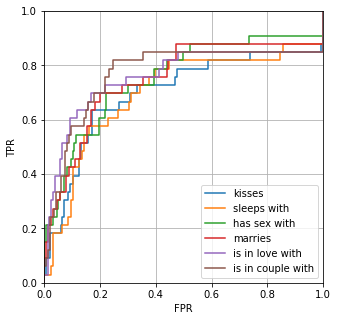

In [8]:
plt.figure(figsize=(5,5))
for v in verb[:-2]:
    fpr, tpr, thresholds = roc_curve(ans[ans[v].notnull()].couple_truth.astype(int),
                                     ans[ans[v].notnull()].loc[:,v])
    plt.plot(fpr,tpr)
plt.grid(True)
plt.legend(verb[:-2]+['kiss and couple'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0,1])
plt.ylim([0,1])
print("AUC = ",auc(fpr,tpr))

In [9]:
# Find the optimal threshold with geometric mean of sensitivity ans specificity
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
optimal_thres = thresholds[index]
print('Sensitivity: {}\nSpecificity: {}\nThreshold: {}'.format(tpr[index],1-fpr[index],optimal_thres))

Sensitivity: 0.8181818181818182
Specificity: 0.7551020408163265
Threshold: 0.2286708801984787


In [16]:
print('Number of True couples according to Hollywood Age Gap: ',len(ans[(ans['couple_truth']==1)]))
v = 'is in couple with'
TN = ans[(ans['couple_truth']==0) & (ans[v]<optimal_thres)]
FN = ans[(ans['couple_truth']==1) & (ans[v]<optimal_thres)]
FP = ans[(ans['couple_truth']==0) & (ans[v]>=optimal_thres)]
TP = ans[(ans['couple_truth']==1) & (ans[v]>=optimal_thres)]
len(TN),len(FN),len(TP),len(FP)

Number of True couples according to Hollywood Age Gap:  33


(111, 6, 27, 36)

## False negatives
True couples not identified by the algorithm

In [11]:
ouf.boxtitle('True couples not identified (FN)')
FN

╭──────────────────────────────────╮
│ True couples not identified (FN) │
╰──────────────────────────────────╯


,movie,release_year,characters,actors,couple_truth,relationship in name,age_gap,genders,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
14,The Quiet American,2002,"[Alden Pyle, Phuong]","[Brendan Fraser, Do Thi Hai Yen]",True,False,13,"[2, 1]",0,0,0.147583,0,0,0,0.085847,0.2864
81,Whatever Works,2009,"[Boris, Melody]","[Larry David, Evan Rachel Wood]",True,False,40,"[2, 1]",0,0,0,0,0,0,0,0
82,Whatever Works,2009,"[Boris, Helena]","[Larry David, Jessica Hecht]",True,False,18,"[2, 1]",0,0,0,0,0,0,0,0
162,Mr. Peabody and the Mermaid,1948,"[Mr. Arthur Peabody, Mermaid]","[William Powell, Ann Blyth]",True,False,37,"[2, 1]",0,0,0,0,0,0,0,0
210,Eternal Sunshine of the Spotless Mind,2004,"[Dr. Howard Mierzwiak, Mary Svevo]","[Tom Wilkinson, Kirsten Dunst]",True,False,35,"[2, 1]",0.506987,0.008996,0.121707,0.063176,0.315709,0.100648,0.068211,0.082241
259,Hollywood Ending,2002,"[Val Waxman, Lori]","[Woody Allen, Debra Messing]",True,False,33,"[2, 1]",0.0,0.011144,0.011017,0.003554,0,0,0,0.162885


### Notes
- In the case of _The Quiet American_, the answer given to "Who is in couple with Alden Pyle?" (with last paragraph) is **"Fowler's Vietnamese mistress Phuong" -> how to know that this is simply Phuong?**
- In the case of _Whatever Works_, the character Melodie St. Ann Celestine is called Melody on Wikipedia. **Use characters' names from Wikipedia'** ✓
- In _Husbands and Wives_, Gabe and Roth kiss only and "share a romantic moment". The kiss is well identified by the algorithm.
- In _Mr. Peabody and the Mermaid_, Mr Peabody is refered to as Arthur Peabody in Wikipedia and the Mermaid is sometimes refered to as Lenore, but she's called Mermaid both in Wikipedia and TMDB cast data. The algorithm identifies that Arthur Peabody and Lenore kiss.
- In _Eternal Sunshine of the Spotless Mind_ the couple Howard and Mary is identified with verbs "kisses" and "is in love with"
- In _Hollywood Ending_, the Plot does not make the relationship between Val and Lori so clear.

### Ideas
- Use a combination of "kisses" and "is in couple with"
- Learn other names for same character from text

AUC =  0.7702239789196311
Number of True couples according to Hollywood Age Gap:  33


(81, 5, 28, 37)

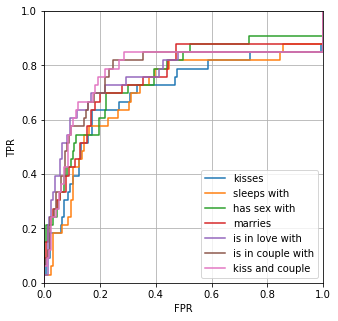

In [15]:
## Combine "kisses" and "is in couple with"

plt.figure(figsize=(5,5))
for v in verb[:-2]:
    fpr, tpr, thresholds = roc_curve(ans[ans[v].notnull()].couple_truth.astype(int),
                                     ans[ans[v].notnull()].loc[:,v])
    plt.plot(fpr,tpr)
fpr, tpr, thresholds = roc_curve(ans[ans[['kisses','is in couple with']].notnull().all(axis=1)].couple_truth.astype(int),
                                 ans[ans[['kisses','is in couple with']].notnull().all(axis=1)].loc[:,['kisses','is in couple with']].max(axis=1))
plt.plot(fpr,tpr)
plt.grid(True)
plt.legend(verb[:-2]+['kiss and couple'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0,1])
plt.ylim([0,1])
print("AUC = ",auc(fpr,tpr))

print('Number of True couples according to Hollywood Age Gap: ',len(ans[(ans['couple_truth']==1)]))
TN_ = ans[(ans['couple_truth']==0) & ((ans[['kisses','is in couple with']]<optimal_thres).all(axis=1,skipna=True))]
FN_ = ans[(ans['couple_truth']==1) & ((ans[['kisses','is in couple with']]<optimal_thres).all(axis=1,skipna=True))]
FP_ = ans[(ans['couple_truth']==0) & ((ans[['kisses','is in couple with']]>=optimal_thres).any(axis=1,skipna=True))]
TP_ = ans[(ans['couple_truth']==1) & ((ans[['kisses','is in couple with']]>=optimal_thres).any(axis=1,skipna=True))]
len(TN_),len(FN_),len(TP_),len(FP_)

## False positives
Not-couples identified as couples by the algorithm

In [17]:
ouf.boxtitle('Not-couples identified as couples (FP)')
display(FP.style.applymap(style_high_score, thres=float(optimal_thres)))

╭────────────────────────────────────────╮
│ Not-couples identified as couples (FP) │
╰────────────────────────────────────────╯


,movie,release_year,characters,actors,couple_truth,relationship in name,age_gap,genders,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
11,Venus,2006,"[""Jessie's Boyfriend"", 'Maurice']","['Bronson Webb', ""Peter O'Toole""]",False,False,51,"[2, 2]",0.084046,0.071626,0.746060,0.320473,0.506200,0.379754,0.373423,0.071534
15,The Quiet American,2002,"['Thomas Fowler', 'Alden Pyle']","['Michael Caine', 'Brendan Fraser']",False,False,36,"[2, 2]",0.021460,0.000700,0.077977,0.040487,0.318553,0.466007,0.560721,nan
32,The Big Lebowski,1998,"['Bunny Lebowski', 'Jackie Treehorn']","['Tara Reid', 'Ben Gazzara']",False,False,45,"[1, 2]",0.003382,0.010717,0.160925,0.000040,0.240076,0.373830,nan,0.223813
37,The Big Lebowski,1998,"['Bunny Lebowski', 'Jeffrey ""The Dude']","['Tara Reid', 'Jeff Bridges']",False,False,26,"[1, 2]",0.005193,0.037729,0.182468,0.090655,0.154682,0.556613,0.040629,0.231219
38,The Big Lebowski,1998,"['Walter Sobchak', 'Donny Kerabatsos']","['John Goodman', 'Steve Buscemi']",False,False,5,"[2, 2]",0.001279,0.006769,0.013309,0.001722,0.001201,0.515686,0.261991,0.008033
48,The Big Lebowski,1998,"['The Dude', 'Walter']","['Jeff Bridges', 'John Goodman']",False,False,3,"[2, 2]",0.038306,0.114548,0.226794,0.032077,0.246923,0.332059,0.041490,nan
76,Poison Ivy,1992,"['Ivy', 'Sylvie Cooper']","['Drew Barrymore', 'Sara Gilbert']",False,False,0,"[1, 1]",0.085226,0.414295,0.314499,0.058821,0.583577,0.437886,0.255267,0.426397
77,Poison Ivy,1992,"['Darryl Cooper', 'Sylvie Cooper']","['Tom Skerritt', 'Sara Gilbert']",False,False,41,"[2, 1]",0.009641,0.029599,0.476460,0.022187,0.151415,0.316317,0.945329,0.122313
78,Poison Ivy,1992,"['Georgie Cooper', 'Ivy']","['Cheryl Ladd', 'Drew Barrymore']",False,False,23,"[1, 1]",0.637216,0.630838,0.788995,0.397866,0.610794,0.870749,0.642987,0.887106
91,Whatever Works,2009,"['Morgenstern', 'Marietta']","['Olek Krupa', 'Patricia Clarkson']",False,False,13,"[2, 1]",0.002636,0.077787,0.175585,nan,0.099639,0.354868,nan,0.889326


### Notes on some examples of FP
- In _Harold and Maude_, "Harold and Maude" is given as an answer both to "Who is in couple with Glaucus?" and "Who is in couple with Girlfriend?". **Ignore answers containing more than one name.** ✓
- In _Venus_, the question "Who is in couple with Jessie's Boyfriend?" with the last paragraph as context obtains the answer "Maurice". The paragraph is indeed a bit ambiguous. No simple solution for this FP. But **Consider character name as an information of the relationship, ex: Jessie's Boyfriend.** ✓
- In _The Quiet American_, Thomas Fowler and Alden Pyle are identified as a couple. It comes from the first paragraph where the plot says that Fowler, Pyle and Phuong are in a love triangle. No simple solution for this FP.
- In _The Big Lebowski_, 
    - Bunny and Jackie are indeed described as lovers ("Revealing Bunny is one of Treehorn's actresses and lovers") -> Original label is wrong.
    - The Dude and Bunny are identified as a couple because of the common name Lebowski ("Outside he meets Bunny, Lebowski's trophy wife"). No simple solution for this FP.
    - Walter Sobchak and Donny Kerabatsos are mentioned as "bowling partners", so there might be a confusion with the term _partners_
    - The Doctor, Chorine Dancer, Maude's Thug are never mentionned in the Wikipedia plot, so it's hard to say why Bunny is detected as his partner. **Skip characters who are not mentionned in the plot.** ✓
    - The Dude and Walter are identified as a couple in the 3rd paragraph where it is stated that "and Walter and The Dude return to the bowling alley". No simple solution for this FP.
- In _Poison Ivy_, 
    - Darryl and Sylvie are identified as a couple, but Darryl is Sylvie's father. This can be easily identified with the question "Who is the father of Sylvie Cooper?" -> answer= Darryl (score=0.9453288316726685). **Ignore identified couples, when other type of relationship has stronger score**
    - There is some ambiguity in the wiki description of the relationships between Ivy and Georgie and between Ivy and Sylvie.
    - Guy and M.D. are not mentionned in the plot
- In _Whatever Works_
    - "Who is in couple with John?": "Boris and Melody" should not be considered a valid answer
    - **Should ignore characters as "Boris' Friend #1","Boris' Friend #2", 'Melodie Club Friend #3**
    - Marietta is in an open relationship with Leo and Morgenstern. So, in this case the question "Who is in couple with Marietta?" being answered "Leo and Morgenstern" (score=0.9626760482788086) is the right answer. However, from the plot it is not clear if Leo and Morgenstern are in a direct relationship.
    - John and Howard are a true couple, 
- In _Entrapment_, the couple Aaron Thibadeaux and Gin is a FP
- In _Husbands and Wives_
    - A relationship is identified between the character Sally and its actress Judy Davis. **Remove actors and actresses names that are presented in parenthesis** ✓
    - Sam and Jack are a true couple ("Jack's new girlfriend, Sam")
    - Michael Gates and Jack are not a true couple
    - Sally and Michael are a true couple ("About a week later, Judy introduces Sally to Michael (Liam Neeson), Judy's magazine colleague, in whom Judy is clearly interested herself.")
    - Gail is not mentionned in the plot
- In _Magnolia_
    - Two actors play Jimmy Gator (Philip Baker Hall and Thomas Jane). **Check when a character has _old_ or _young_ in his/her name and try to identify which actor is the right one**
    - The algorithm has some trouble making the difference between Jim Kurring and Jimmy Gator. **If I only consider paragraphs where the character has being mentioned, this problem can go away.**
    - Burt Ramsey is never mentioned in the plot
- In _Mr. Peabody and the Mermaid_
    - Mr Peabody and Polly are a true couple ("Peabody had gone on vacation with his wife Polly")
    - Polly and Mike Fitzgerald are a true couple ("Polly, who is herself attracted to suave Englishman Mike Fitzgerald")
    - Major Hadley never appears in the plot
- In _First Knight_
- In _Something's Gotta Give_
- In _Eternal Sunshine of the Spotless Mind_
- In _Lost in Translation_
- In _Shopgirl_
- In _Wild Target_, the actor who plays Victor Maynard is identified as a character (**should remove the artists names in parenthesis** ✓). Also Tony and Victor are identified as a couple, witch probably comes from the sentence "For a while Victor mistakenly wonders if he is sexually attracted to Tony".
- In _Hollywood Ending_
- In _The Mother_

### Conclusion
- The algorithm identifies some true couples that were not manually entered in the Hollywood Age Gap dataset. 
- Some identified couples correspond to other types of relationships (ex: friends, mother-child, father-child)

In [19]:
def show_score_by_paragraph(movie, release_year, character, v = 'is in couple with'):# code to test
    document_string  = wiki_df[(wiki_df.movie==movie) & (wiki_df.release_year==release_year)]['Plot'].iloc[0]
    p = get_character_nickname(character)
    
    for context in document_string.split('\n'):
        print('> ',context)
        if not len(context):
            continue
            
        # Only ask question when the character p is mentionned in the context
        if not character_is_mentionned(p,context):
            continue
                    
        ouf.b('Who {} {}?'.format(v,p))
        QA_input = {
            'question': 'Who {} {}?'.format(v,p),
            'context': context
        }
        a = qa(QA_input)
        print(a['answer'],a['score'],'\n')
    
show_score_by_paragraph('Mr. Peabody and the Mermaid', 1948, 'Arthur Peabody', 'is in couple with')
print('---\n')
show_score_by_paragraph('Mr. Peabody and the Mermaid', 1948, 'Arthur Peabody', 'kisses')


>  Much of the story is shown in flashback as Arthur Peabody tells a skeptical doctor about the source of his malaise.
Who is in couple with Arthur Peabody?
doctor 4.4035219616489485e-05 

>  After a bad bout of influenza, Peabody had gone on vacation with his wife Polly to the fictional Caribbean resort of St Hilda. While there, he hears singing coming from a rocky cay offshore and sails his boat to investigate and do a little fishing. To his embarrassment, he reels in a beautiful mermaid whom he names Lenore. Although mute, she is mischievous and childlike and more than a little alluring – so much so that before long Peabody has taught her to kiss. Meanwhile, he hides Lenore in the resort’s deep fish pond.
Who is in couple with Arthur Peabody?
Polly 0.6755793690681458 

>  Confusion ensues as Peabody's wife Polly, who is herself attracted to suave Englishman Mike Fitzgerald, suspects her husband of infidelity with a vacationing singer. Things get more complicated after Polly storms o

## Other types of relationships confusion
Some characters are identified as in couple when they have other type of relationship (ex: friends, mother-child, father-child).

In [20]:
ans[ans['is the father of']>0.9].style.applymap(style_high_score, thres=0.3)

,movie,release_year,characters,actors,couple_truth,relationship in name,age_gap,genders,kisses,sleeps with,has sex with,marries,is in love with,is in couple with,is the father of,is the mother of
75,Poison Ivy,1992,"['Darryl Cooper', 'Ivy']","['Tom Skerritt', 'Drew Barrymore']",True,False,41,"[2, 1]",0.044158,0.076289,0.907812,0.250785,0.266676,0.512599,0.956571,0.225497
77,Poison Ivy,1992,"['Darryl Cooper', 'Sylvie Cooper']","['Tom Skerritt', 'Sara Gilbert']",False,False,41,"[2, 1]",0.009641,0.029599,0.476460,0.022187,0.151415,0.316317,0.945329,0.122313
92,Whatever Works,2009,"['John', 'Howard']","['Ed Begley Jr.', 'Christopher Evan Welch']",False,False,16,"[2, 2]",0.463825,0.606709,0.867845,0.673023,0.900495,0.931472,0.905568,0.194885
184,Something's Gotta Give,2003,"['Harry Sanborn', 'Marin Klein']","['Jack Nicholson', 'Amanda Peet']",True,False,35,"[2, 1]",0.041140,0.114438,0.934280,0.867911,0.957556,0.968610,0.963862,0.435517
277,The Mother,2003,"['May', 'Bobby']","['Anne Reid', 'Steven Mackintosh']",False,False,32,"[1, 2]",0.040032,0.040839,0.188076,0.016313,0.203322,0.610287,0.903274,0.732677


### Notes
- In _Poison Ivy_ Darryl is the father of Sylvie, but not of Ivy
- In _Whatever Works_, John and Howard are lovers
- In _Something's Gotta Give_, Harry and Marin are lovers. Although Harry ends up getting married with Marin's mother.
- In _The Mother_, May is the mother of Bobby.

### Conclusion
The performance is not sufficient. By removing identified father-child relationships from identified couples, we might miss some real (and interesting) couples.

# Issues
- When same character is played by more than one actor/actress (ex: young/old Rose in Titanic)
- Characters' names presented differently at TMDB and Wikipedia (ex: Mr Peabody = Arthur Peabody in Mr. Peabody and the Mermaid)